In [ ]:
import torch
import torch.nn as nn
from model_archi import PlantVillageCNN
from utlis import get_data_loaders

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PlantVillageCNN().to(device)
model.load_state_dict(torch.load('sequential_model.pth'))

C:\Users\KNYpe\AppData\Local\Temp\ipykernel_10704\1623833996.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('sequential_model.pth'))


<All keys matched successfully>

Define the LoRA parameterization as described in the paper. The full detail on how PyTorch parameterizations work is here: https://pytorch.org/tutorials/intermediate/parametrizations.html



In [17]:
class LoRAParametrization(nn.Module):
    def __init__(self, features_in, features_out, rank = 1, alpha = 1, device = device):
        super().__init__()
        self.lora_A = nn.Parameter(torch.zeros(rank,features_in, device = device))
        self.lora_B = nn.Parameter(torch.zeros(features_out,rank , device = device))
        nn.init.normal_(self.lora_A, mean=0, std=0.1)

        self.scale = alpha / rank
        self.enabled = True

    def forward(self, original_weights):
        if self.enabled:
            # Return W + (B*A)*scale
            return original_weights + torch.matmul(self.lora_B, self.lora_A).view(original_weights.shape) * self.scale
        else:
            return original_weights

Add the ( linear and convolution) parameterization to our network.

In [ ]:
import torch.nn.utils.parametrize as parametrize

def linear_layer_parameterization(layer, device, rank=1, lora_alpha=1):

    features_in, features_out = layer.weight.shape
    return LoRAParametrization(
        features_in, features_out, rank=rank, alpha=lora_alpha, device=device
    )

def conv_layer_parameterization(layer, device, rank=1, lora_alpha=1):
    in_channels, out_channels, kernel_height, kernel_width = layer.weight.shape
    return LoRAParametrization(
        in_channels * kernel_height * kernel_width,
        out_channels,
        rank=rank,
        alpha=lora_alpha,
        device=device
    )


In [ ]:
# Applying the parameterization with the corrected function
for index, layer in enumerate(model.children()):
    if isinstance(layer, nn.Conv2d):
        parametrize.register_parametrization(
            layer, "weight", conv_layer_parameterization(layer, layer.weight.device)
        )
    elif isinstance(layer, nn.Linear):
        parametrize.register_parametrization(
            layer, "weight", linear_layer_parameterization(layer, layer.weight.device)
        )


Display the number of parameters added by LoRA.



In [20]:
total_parameters_lora = 0
total_parameters_non_lora = 0
for index, layer in enumerate(model.children()):
    if hasattr(layer, 'weight'):
        total_parameters_lora += layer.parametrizations["weight"][0].lora_A.nelement() + layer.parametrizations["weight"][0].lora_B.nelement()
        total_parameters_non_lora += layer.weight.nelement() + layer.bias.nelement()
        print(
            f'Layer {index+1}: W: {layer.weight.shape} + B: {layer.bias.shape} + Lora_A: {layer.parametrizations["weight"][0].lora_A.shape} + Lora_B: {layer.parametrizations["weight"][0].lora_B.shape}'
        )


Layer 1: W: torch.Size([32, 3, 3, 3]) + B: torch.Size([32]) + Lora_A: torch.Size([1, 288]) + Lora_B: torch.Size([3, 1])
Layer 3: W: torch.Size([16, 32, 3, 3]) + B: torch.Size([16]) + Lora_A: torch.Size([1, 144]) + Lora_B: torch.Size([32, 1])
Layer 5: W: torch.Size([8, 16, 3, 3]) + B: torch.Size([8]) + Lora_A: torch.Size([1, 72]) + Lora_B: torch.Size([16, 1])
Layer 7: W: torch.Size([128, 2048]) + B: torch.Size([128]) + Lora_A: torch.Size([1, 128]) + Lora_B: torch.Size([2048, 1])
Layer 9: W: torch.Size([10, 128]) + B: torch.Size([10]) + Lora_A: torch.Size([1, 10]) + Lora_B: torch.Size([128, 1])


In [21]:
# we have form train.ipynb
total_parameters_original = 270242

In [22]:
assert total_parameters_non_lora == total_parameters_original
print(f'Total number of parameters (original): {total_parameters_non_lora:,}')
print(f'Total number of parameters (original + LoRA): {total_parameters_lora + total_parameters_non_lora:,}')
print(f'Parameters introduced by LoRA: {total_parameters_lora:,}')
parameters_incremment = (total_parameters_lora / total_parameters_non_lora) * 100
print(f'Parameters incremment: {parameters_incremment:.3f}%')

Total number of parameters (original): 270,242
Total number of parameters (original + LoRA): 273,111
Parameters introduced by LoRA: 2,869
Parameters incremment: 1.062%


Freeze all the parameters of the original network and only fine tuning the ones introduced by LoRA. Then fine-tune the model on the class "Tomato___Bacterial_spot"

In [23]:
for name, param in model.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False

Freezing non-LoRA parameter conv1.bias
Freezing non-LoRA parameter conv1.parametrizations.weight.original
Freezing non-LoRA parameter conv2.bias
Freezing non-LoRA parameter conv2.parametrizations.weight.original
Freezing non-LoRA parameter conv3.bias
Freezing non-LoRA parameter conv3.parametrizations.weight.original
Freezing non-LoRA parameter fc1.bias
Freezing non-LoRA parameter fc1.parametrizations.weight.original
Freezing non-LoRA parameter fc2.bias
Freezing non-LoRA parameter fc2.parametrizations.weight.original


In [24]:
train_loader, val_loader = get_data_loaders(train_dir = "../Datasets/finetuning")

16


In [25]:
import torch.optim as optim
from tqdm import tqdm
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 8

In [ ]:
from training_utils import train_model

# Train the model
training_history = train_model(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=criterion, 
    optimizer=optimizer, 
    num_epochs=num_epochs, 
    device=device,
)

Validating: 100%|██████████| 16/16 [00:02<00:00,  7.21it/s]


Epoch [1/8] | Training Loss: 1.7468 | Validation Loss: 0.7533 | Validation Accuracy: 0.7470 


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.16it/s]


Epoch [2/8] | Training Loss: 1.8048 | Validation Loss: 0.7518 | Validation Accuracy: 0.7490 


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.51it/s]


Epoch [3/8] | Training Loss: 1.7384 | Validation Loss: 0.7499 | Validation Accuracy: 0.7510 


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.64it/s]


Epoch [4/8] | Training Loss: 1.7575 | Validation Loss: 0.7478 | Validation Accuracy: 0.7530 


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.84it/s]


Epoch [5/8] | Training Loss: 1.6872 | Validation Loss: 0.7454 | Validation Accuracy: 0.7550 


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.84it/s]


Epoch [6/8] | Training Loss: 1.6728 | Validation Loss: 0.7429 | Validation Accuracy: 0.7620 


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.50it/s]


Epoch [7/8] | Training Loss: 1.6173 | Validation Loss: 0.7407 | Validation Accuracy: 0.7620 


Validating: 100%|██████████| 16/16 [00:02<00:00,  7.89it/s]

Epoch [8/8] | Training Loss: 1.5481 | Validation Loss: 0.7388 | Validation Accuracy: 0.7610 
Training completed!


We can see the results is better as we have finetuned on the "Tomato___Bacterial_spot" class datasets.

From 32% to 49%

In [27]:
from visualization_utils import plot_class_accuracies, evaluate_model

# Your existing class labels
class_labels = ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy',
                'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot',
                'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot',
                'Tomato___Tomato_mosaic_virus', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus']

# Evaluate the model
overall_accuracy, accuracies, wrong_counts = evaluate_model(model, val_loader, class_labels, device)

Overall Accuracy: 0.761
Wrong predictions for class Tomato___Bacterial_spot: 51
Class Tomato___Bacterial_spot Accuracy: 0.49
Wrong predictions for class Tomato___Early_blight: 45
Class Tomato___Early_blight Accuracy: 0.55
Wrong predictions for class Tomato___healthy: 18
Class Tomato___healthy Accuracy: 0.82
Wrong predictions for class Tomato___Late_blight: 32
Class Tomato___Late_blight Accuracy: 0.68
Wrong predictions for class Tomato___Leaf_Mold: 19
Class Tomato___Leaf_Mold Accuracy: 0.81
Wrong predictions for class Tomato___Septoria_leaf_spot: 21
Class Tomato___Septoria_leaf_spot Accuracy: 0.79
Wrong predictions for class Tomato___Spider_mites Two-spotted_spider_mite: 41
Class Tomato___Spider_mites Two-spotted_spider_mite Accuracy: 0.59
Wrong predictions for class Tomato___Target_Spot: 5
Class Tomato___Target_Spot Accuracy: 0.95
Wrong predictions for class Tomato___Tomato_mosaic_virus: 0
Class Tomato___Tomato_mosaic_virus Accuracy: 1.0
Wrong predictions for class Tomato___Tomato_Yell

The performance of the model is better all thanks to LoRA finetuning

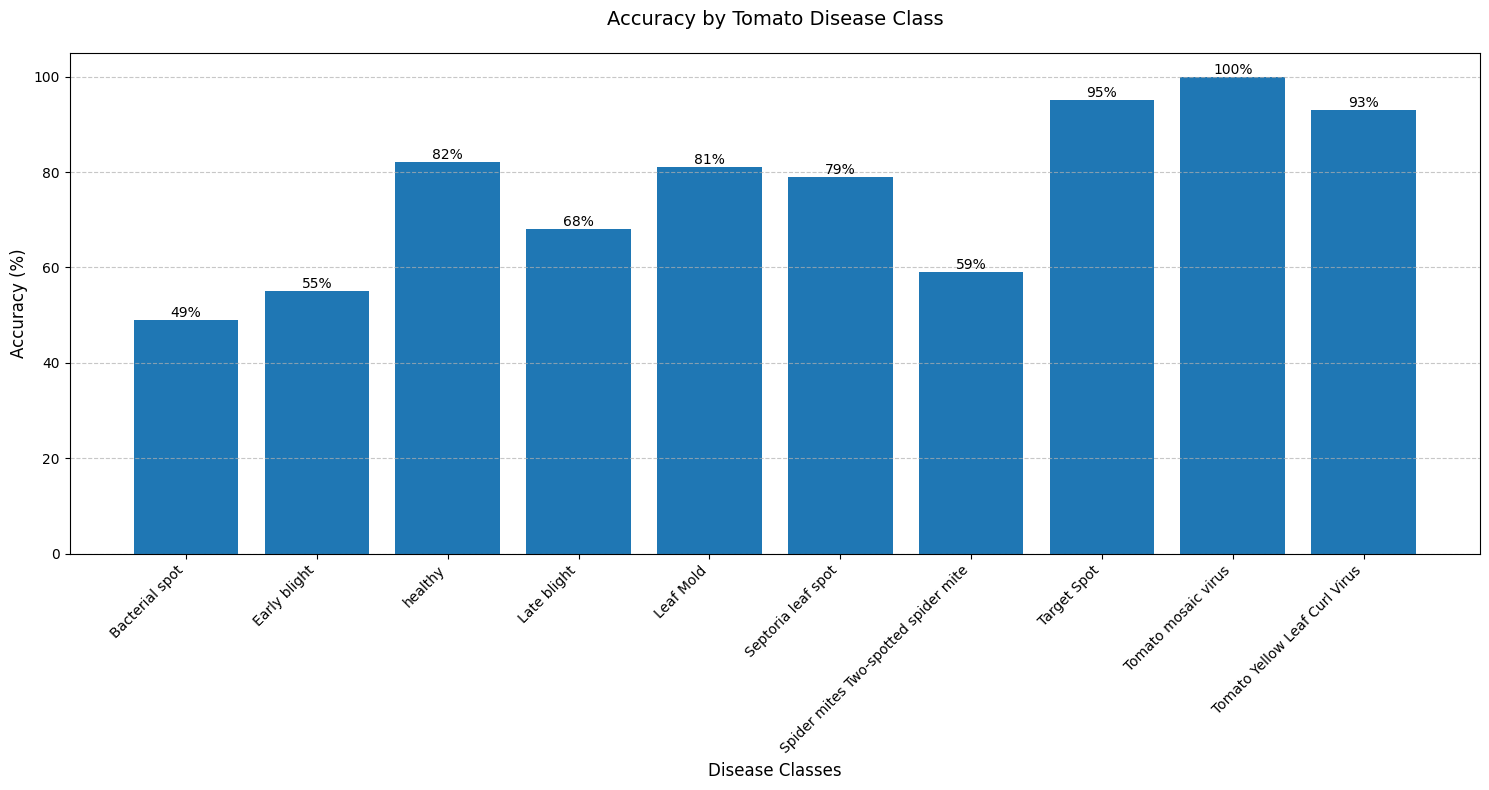

In [ ]:
plot_class_accuracies(class_labels, accuracies)